# Wavelength smoothing

We know there's a lot of frame to frame noise in the row sums, so let's try taking a closer look at the pixel (or wavelength index) level noise. Heatmap time.

## Notebooks set-up

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


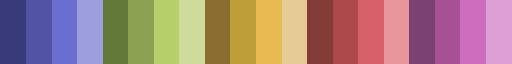

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
from pathlib import Path

# Third party imports
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps as cm
from scipy.signal import savgol_filter

# Local imports
import configuration as config

# Make sure the figures directory exists
figures_dir = f'{config.FIGURES_DIRECTORY}/signal_extraction'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

colormap = cm.get_cmap('tab20b')
colors = colormap.colors
blue = colors[0]
light_blue = colors[1]
green = colors[4]
yellow = colors[9]
red = colors[13]
light_red = colors[14]
purple = colors[16]
colormap

## 1. Load test frame

In [2]:
# Load corrected data
with h5py.File(f'{config.SIGNAL_CORRECTED_DIRECTORY}/train.h5', 'r') as hdf:
    corrected_airs_signal = hdf[config.SAMPLE_PLANET]['AIRS-CH0_signal'][:]

## 2. Wavelength signal over time

In [3]:
# Sum across axis 2
row_sums = np.sum(corrected_airs_signal, axis=2)
print(f'Raw signals shape: {corrected_airs_signal.shape}')

# Get top 10 rows for each frame
top_rows = np.argsort(row_sums, axis=1)[:, -10:]

# Now index the original array to get the top rows for each frame
signal_strip = corrected_airs_signal[:, top_rows[1], :]
print(f'Extracted signal shape: {signal_strip.shape}')

# Sum the extracted rows and transpose so that the wavelength index is the row
# and the frame is the column
frame_spectrums = np.transpose(np.sum(signal_strip, axis=1))
print(f'Frame spectrum shape: {frame_spectrums.shape}')

# Standardize each wavelength across the frames
row_means = np.mean(frame_spectrums, axis=1)
row_stds = np.std(frame_spectrums, axis=1)

frame_spectrums = (frame_spectrums - row_means[:, np.newaxis]) / row_stds[:, np.newaxis]
print(f'Standardized frame spectrum: {frame_spectrums.shape}')

Raw signals shape: (5625, 32, 282)
Extracted signal shape: (5625, 10, 282)
Frame spectrum shape: (282, 5625)
Standardized frame spectrum: (282, 5625)


This is very cool way of setting up the problem already - we have taken the whole dataset for this star and reduced it to a 2D, one channel image of sorts (a spectrogram, really) - CNN anyone?

We have a lot of noise in the raw data for a given wavelength's intensity over time. Let's try a few different methods to smooth it:

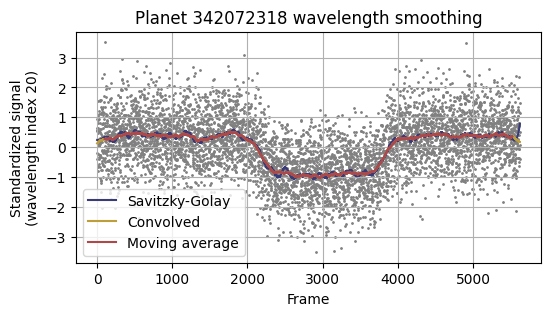

Savgol shape: (5625,)
Convolved shape: (5625,)
Moving average shape: (5426,)


In [4]:
wavelength_index = 20
window_length = 200


def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')

    return y_smooth

convolved = smooth(frame_spectrums[wavelength_index], window_length)

cumsum_vec = np.cumsum(np.insert(frame_spectrums[wavelength_index], 0, 0)) 
ma_vec = (cumsum_vec[window_length:] - cumsum_vec[:-window_length]) / window_length

savgol = savgol_filter(frame_spectrums[wavelength_index], window_length, 3)

plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH/2))
plt.title(f'Planet {config.SAMPLE_PLANET} wavelength smoothing')

plt.scatter(range(len(frame_spectrums[wavelength_index])), frame_spectrums[wavelength_index], color='gray', s=1)
plt.plot(range(len(savgol)), savgol, color=blue, label='Savitzky-Golay')
plt.plot(range(len(convolved)), convolved, color=yellow, label='Convolved')
plt.plot(range(window_length//2, window_length//2 + len(ma_vec)), ma_vec, color=red, label='Moving average')
plt.xlabel('Frame')
plt.ylabel(f'Standardized signal\n(wavelength index {wavelength_index})')
plt.grid()
plt.legend(markerscale=5)
plt.savefig(
    f'{figures_dir}/02.4-wavelength_smoothing.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)
plt.show()

print(f'Savgol shape: {savgol.shape}')
print(f'Convolved shape: {convolved.shape}')
print(f'Moving average shape: {ma_vec.shape}')

Let's use the cumsum moving average - it's going to be the most performant. We can apply it to all of the wavelengths in one shot:

In [5]:
def moving_average_rows(a, n):

    # Compute cumulative sum along axis 1 (across columns)
    cumsum_vec = np.cumsum(a, axis=1, dtype=float)

    # Subtract the cumulative sum at the start of the window from the end
    cumsum_vec[:, n:] = cumsum_vec[:, n:] - cumsum_vec[:, :-n]
    
    # Return the average for each window, starting from the (n-1)th element
    return cumsum_vec[:, n - 1:] / n

ma = moving_average_rows(frame_spectrums, window_length)
print(f'Smoothed frame spectra shape: {ma.shape}')

Smoothed frame spectra shape: (282, 5426)


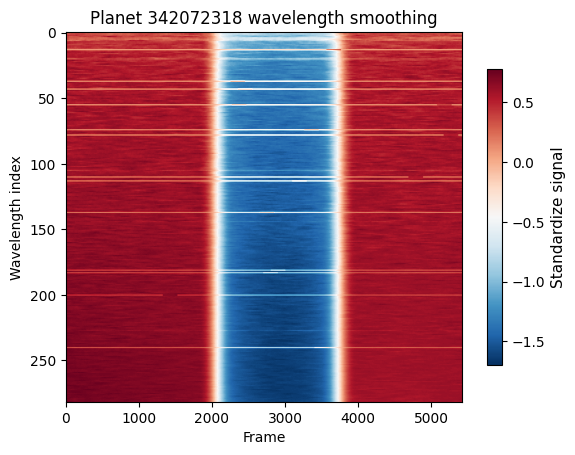

In [6]:
plt.title(f'Planet {config.SAMPLE_PLANET} wavelength smoothing')
im = plt.imshow(ma, aspect='auto', cmap='RdBu_r')
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Standardize signal', fontsize=11)
plt.xlabel('Frame')
plt.ylabel('Wavelength index')
plt.savefig(
    f'{figures_dir}/02.4-smoothed_wavelength_spectrogram.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)
plt.show()

Nice! Sanity check that we haven't deformed the data.

In [7]:
# Transpose back to original shape
ma = np.transpose(ma)
print(f'Smoothed frame spectra shape: {ma.shape}')

# Sum across wavelengths
summed_ma = np.sum(ma, axis=1)
print(f'Smoothed and summed frame spectra shape: {ma.shape}')

# Standardize the summed signal
summed_ma = (summed_ma - np.mean(summed_ma)) / np.std(summed_ma)

# Get and standardize total flux for comparison
total_flux = [np.sum(frame) for frame in corrected_airs_signal]
total_flux = (total_flux - np.mean(total_flux)) / np.std(total_flux)

Smoothed frame spectra shape: (5426, 282)
Smoothed and summed frame spectra shape: (5426, 282)


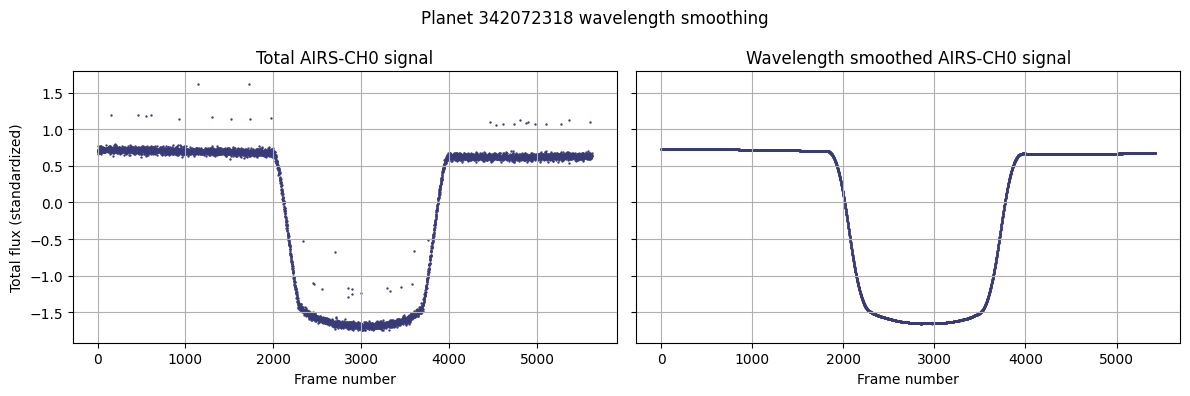

In [8]:
# Transit plot 
fig, axs = plt.subplots(1,2, sharey=True, figsize=(config.STD_FIG_WIDTH * 2, config.STD_FIG_WIDTH - 2))
fig.suptitle(f'Planet {config.SAMPLE_PLANET} wavelength smoothing')

axs[0].set_title(f'Total AIRS-CH0 signal')
axs[0].scatter(list(range(len(total_flux))), total_flux, color=blue, s=0.5)
axs[0].set_xlabel('Frame number')
axs[0].set_ylabel('Total flux (standardized)')
axs[0].grid()

axs[1].set_title(f'Wavelength smoothed AIRS-CH0 signal')
axs[1].scatter(list(range(len(summed_ma))), summed_ma, color=blue, s=0.5)
axs[1].set_xlabel('Frame number')
axs[1].grid()

fig.tight_layout()

fig.savefig(
    f'{figures_dir}/02.4-transit_plot_total_vs_wavelength_smoothed.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)